# Projeto final de Aprendizado de Máquina: análise e predição de dados clínicos
## UFMG - 2023/1 - Professor Adriano Veloso
### Luís Felipe Ramos Ferreira - 2019022553

Link para apresentação no youtube: link

# Introdução

O projeto final implementado e apresentado neste *notebook* apresenta a aplicação de conceitos e algoritmos de Aprendizado de Máquina em um contexto da área da saúde. Mais especificamente, os dados utilizados foram fornecidos por uma equipe ligada ao Hospital das Clínicas de Belo Horizonte e representam condições e características relacionadas a pacientes internados nos hospitais, como apresentação de comorbidades, resultados de exames fisiológicos, complicações durante internação, etc.

O objetivo principal com a utilização destes dados é prever, a partir destas informações, o período de tempo que o paciente irá ficar internado na UTI (Unidade de Tratamento Intensivo), de modo que os custos e equipamentos possam ser redirecionados da maneira correta e, dessa maneira, o maior número de vidas possam ser salvas.

Nesse cenário, duas abordagens podem ser levados em consideração. Como o tempo de internação na UTI esta presente nos dados como uma variável numérica, pode-se lidar coma  situação como um problema de regressão. No entanto, para aumentar o paradigma de estuda, podemos discretizar os dados relativos ao tempo de internação, em categorias que separam os pacientes entre aqueles ue ficaram mais ou menos que 3 dias internados, por exemplo. Assim, vários algoritmos e abordagens diferentes podem ser analisados.

Em resumo, o problema consiste em, possuindo dados relativos à admissão de um apciente no hospital, como dados de comorbidades, idade, dados fisiológicos de exames, etc, seja possível fazer uma previsão adequada do tempo que o paciente ficará internado na UTI. Naturalmente, este é um problema difícil, mas com grande importância em uma escala global.

# Metodologia



In [103]:
import os
import sys
import numpy as np
import pandas as pd
import numpy.typing as npt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import json
import time
import xgboost as xgb

# Constantes

blablabla

In [104]:
RANDOM_STATE: np.int8 = 17
TEST_SIZE: np.float64 = 0.2

MAXIMUM_UNIT_LENGTH_STAY: np.int32 = 24
NUMBER_OF_BINS: np.int8 = 2

# Base de dados

In [105]:
# getting data from comorbidades and capacidade funcional, plus ages and labels
df: pd.DataFrame = pd.read_csv("data/raw/folha3.csv")
ages: pd.Series = df["Age"].copy()
df: pd.DataFrame = df[df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)].copy()
df.dropna(axis=1, thresh=5000, inplace=True)
df.fillna(value=0, inplace=True)
labels: pd.DataFrame = df["UnitLengthStay"].copy()
df = df.iloc[:, 22:]
sheet_3_df: pd.DataFrame = (df == "Verdadeiro").astype(int)

# getting data from motivos de internação na UTI
df = pd.read_csv("data/raw/folha4.csv")
df: pd.DataFrame = df[df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)].copy()
df = df.iloc[:, 21:]
df.dropna(axis=1, thresh=5000, inplace=True)
df.fillna(value=0, inplace=True)
sheet_4_df: pd.DataFrame = (df == "Verdadeiro").astype(int)

# getting data from complicações no primeiro dia na uti
df = pd.read_csv("data/raw/folha5.csv")
df: pd.DataFrame = df[df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)].copy()
df = df.iloc[:, 21:]
df.dropna(axis=1, thresh=5000, inplace=True)
df.fillna(value=0, inplace=True)
sheet_5_df: pd.DataFrame = (df == "Verdadeiro").astype(int)

# getting data from dados fisiologicos na UTI
df = pd.read_csv("data/raw/folha6.csv")
df: pd.DataFrame = df[df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)].copy()
df = df.iloc[:, 21:]
df.dropna(axis=1, thresh=5000, inplace=True)
df.fillna(value=0, inplace=True)
sheet_6_df: pd.DataFrame = df.copy()

# joining dataframes
final_data: pd.DataFrame = pd.concat([ages, sheet_3_df, sheet_4_df, sheet_5_df, sheet_6_df], axis=1, join="inner")

labels_regression: pd.DataFrame = labels.copy()
labels_classification: pd.DataFrame = pd.cut(x=labels_regression, bins=[0, 2, MAXIMUM_UNIT_LENGTH_STAY], labels=np.arange(NUMBER_OF_BINS))

(array([4917.,  975.,  419.,  304.,  128.,   69.,   88.,   36.,   35.,
          32.]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <BarContainer object of 10 artists>)

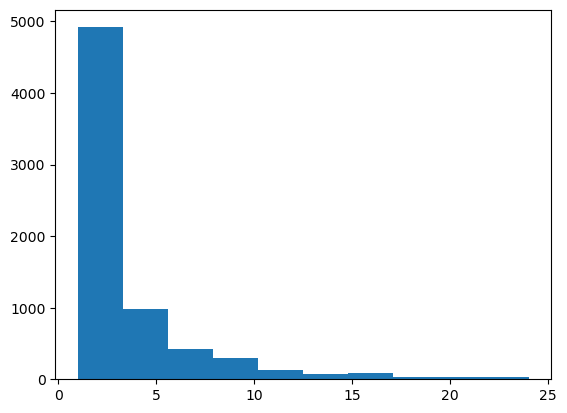

In [106]:
plt.hist(labels_regression)

# Utilitários

In [107]:
def get_run_info(
    y_true: npt.NDArray[np.float64],
    y_pred: npt.NDArray[np.float64],
    type: np.str_ = "classification",
    dump: np.bool_ = False,
) -> dict:
    if type == "classification":
        accuracy_score: np.float64 = metrics.accuracy_score(
            y_true=y_true, y_pred=y_pred
        )
        precision_score: np.float64 = metrics.precision_score(
            y_true=y_true, y_pred=y_pred
        )
        recall_score: np.float64 = metrics.recall_score(y_true=y_true, y_pred=y_pred)
        f1_score: np.float64 = metrics.f1_score(y_true=y_true, y_pred=y_pred)
        confusion_matrix: npt.NDArray[np.int32] = metrics.confusion_matrix(
            y_true=y_true, y_pred=y_pred
        )

        run_info: dict = {
            "accuracy_score": accuracy_score,
            "precision_score": precision_score,
            "recall_score": recall_score,
            "f1_score": f1_score,
            "confusion_matrix": confusion_matrix,
        }
    else:  # regression
        mean_squared_error: np.float64 = metrics.mean_squared_error(
            y_true=y_true, y_pred=y_pred
        )
        root_mean_squared_error: np.float64 = metrics.mean_squared_error(
            y_true=y_true, y_pred=y_pred, squared=False
        )
        mean_absolute_error: np.float64 = metrics.mean_absolute_error(
            y_true=y_true, y_pred=y_pred
        )

        run_info: dict = {
            "mean_squared_error": mean_squared_error,
            "root_mean_squared_error": root_mean_squared_error,
            "mean_absolute_error": mean_absolute_error,
        }
    
    if dump:
        with open(f"{type}_run_info{time.time()}") as file:
            json.dump(run_info, file, indent=4)

    return run_info

# REGRESSION

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    final_data, labels_regression, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
NUMBER_OF_ESTIMATORS: np.int32 = 100

In [109]:
model = RandomForestRegressor(n_estimators=NUMBER_OF_ESTIMATORS)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_test, y_pred, type="regression")

{'mean_squared_error': 10.525873311741613,
 'root_mean_squared_error': 3.2443602315004436,
 'mean_absolute_error': 2.0392523197715917}

In [110]:
from sklearn.model_selection import cross_val_score

In [111]:
model = xgb.XGBRegressor(n_estimators=NUMBER_OF_ESTIMATORS, n_jobs=-1, colsample_bytree=0.7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_true=y_test, y_pred=y_pred, type="regression")

{'mean_squared_error': 11.311024194775793,
 'root_mean_squared_error': 3.3631866131357913,
 'mean_absolute_error': 2.0721116658621903}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

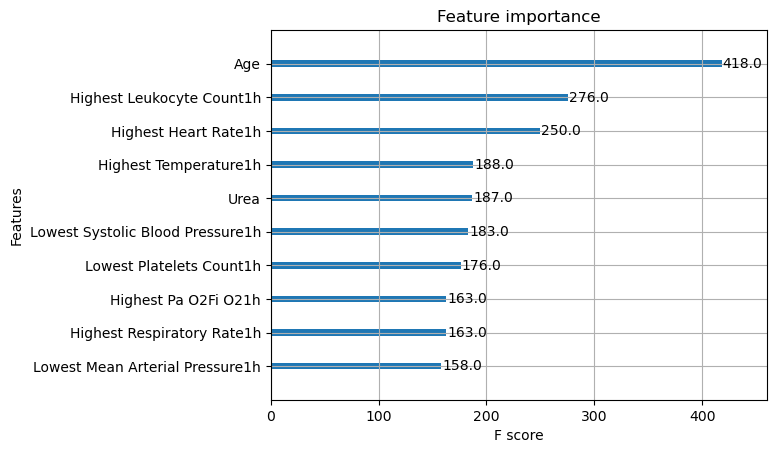

In [112]:
xgb.plot_importance(booster=model, max_num_features=10)

# CLASSIFICATION

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    final_data, labels_classification, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
NUMBER_OF_ESTIMATORS: np.int32 = 400

In [114]:
model = xgb.XGBClassifier(n_estimators=NUMBER_OF_ESTIMATORS, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_true=y_test, y_pred=y_pred)

{'accuracy_score': 0.6780870806566738,
 'precision_score': 0.6466552315608919,
 'recall_score': 0.6061093247588425,
 'f1_score': 0.6257261410788382,
 'confusion_matrix': array([[573, 206],
        [245, 377]])}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

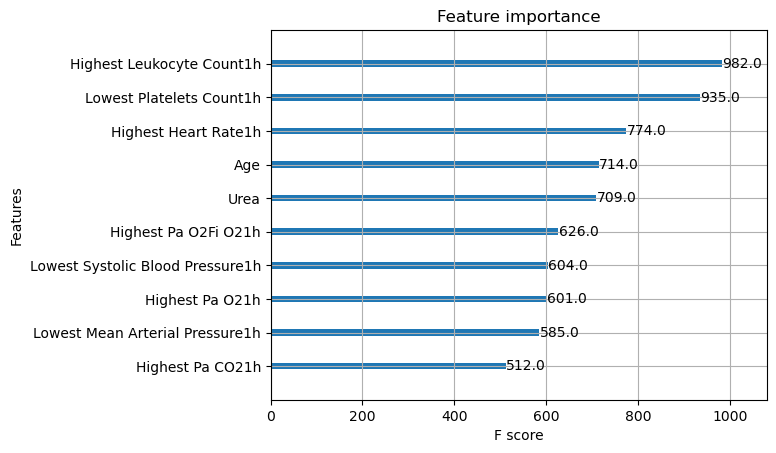

In [115]:
xgb.plot_importance(booster=model, max_num_features=10)

In [116]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_test, y_pred)

{'accuracy_score': 0.6766595289079229,
 'precision_score': 0.6840958605664488,
 'recall_score': 0.5048231511254019,
 'f1_score': 0.5809435707678076,
 'confusion_matrix': array([[634, 145],
        [308, 314]])}

In [122]:
from sklearn.svm import SVC

model = SVC(degree=3, probability=True, kernel="sigmoid")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_run_info(y_test, y_pred)

Referencias

https://arxiv.org/pdf/1603.02754.pdf
